In [ ]:
# ==========================================================
# Google Colab code: Multinomial Naive Bayes (improved version)
# Connect to Google Drive, load dataset, train, and evaluate
# ==========================================================

# Step 1: Install required libraries
!pip install scikit-learn nltk

# Step 2: Import libraries
import pandas as pd
import numpy as np
import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, f1_score

# Download stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# Step 3: Connect Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Adjust this path to where your dataset is stored in Drive
# Example: if the file is in My Drive directly
file_path = "/content/drive/MyDrive/Colab Notebooks/fake_job_postings.csv"

# Load dataset
df = pd.read_csv(file_path)
print("Dataset loaded. Shape:", df.shape)
print(df.head())

# Assuming 'description' column is the job text, and 'fraudulent' is the label
texts = df['description'].astype(str)
labels = df['fraudulent']

# Step 4: Preprocessing function
def clean_text(text):
    text = text.lower()                          # lowercase
    text = re.sub(r'[^a-z\s]', '', text)         # remove special chars/numbers
    text = " ".join([w for w in text.split() if w not in stop_words]) # remove stopwords
    return text

texts = texts.apply(clean_text)

# Step 5: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

# Step 6: Feature extraction with TF-IDF (including bigrams)
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=10000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Step 7: Train MultinomialNB with GridSearch for alpha
params = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]}
grid = GridSearchCV(MultinomialNB(), param_grid=params, cv=5, scoring='f1_macro')
grid.fit(X_train_vec, y_train)

print("Best parameters:", grid.best_params_)
model = grid.best_estimator_

# Step 8: Evaluate
y_pred = model.predict(X_test_vec)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='macro'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset loaded. Shape: (17880, 18)
   job_id                                      title            location  \
0       1                           Marketing Intern    US, NY, New York   
1       2  Customer Service - Cloud Video Production      NZ, , Auckland   
2       3    Commissioning Machinery Assistant (CMA)       US, IA, Wever   
3       4          Account Executive - Washington DC  US, DC, Washington   
4       5                        Bill Review Manager  US, FL, Fort Worth   

  department salary_range                                    company_profile  \
0  Marketing          NaN  We're Food52, and we've created a groundbreaki...   
1    Success          NaN  90 Seconds, the worlds Cloud Video Production ...   
2        NaN          NaN  Valor Services provides Workforce Solutions th...   
3      Sales          NaN  Our passion for improving qualit

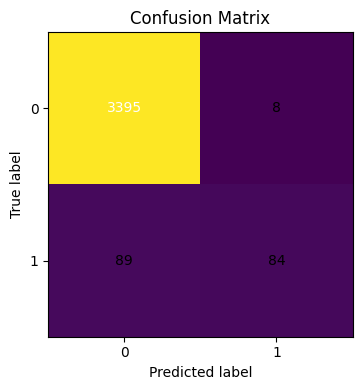

AUC: 0.9511


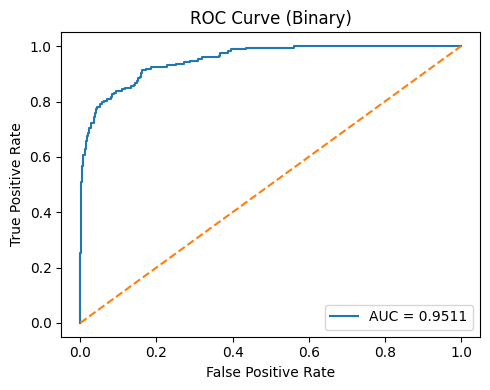

In [ ]:
# ============================================
# Confusion Matrix and ROC/AUC (post-hoc only)
# ============================================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
fig = plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
tick_marks = np.arange(cm.shape[0])
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

# annotate counts
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()

# --- ROC Curve & AUC ---
# Works for binary classification. If multiclass, this will be skipped safely.
try:
    classes_ = model.classes_
    proba = model.predict_proba(X_test_vec)

    if len(classes_) == 2:
        # pick positive class index robustly
        if 1 in classes_:
            pos_idx = np.where(classes_ == 1)[0][0]
        else:
            # fallback to the second class as "positive"
            pos_idx = 1

        y_score = proba[:, pos_idx]

        # Ensure y_test is a 1D array of class labels
        y_true = np.array(y_test)

        fpr, tpr, _ = roc_curve(y_true, y_score, pos_label=classes_[pos_idx])
        auc_val = roc_auc_score(y_true, y_score)

        print(f"AUC: {auc_val:.4f}")

        fig = plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, label=f'AUC = {auc_val:.4f}')
        plt.plot([0,1], [0,1], linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve (Binary)')
        plt.legend(loc='lower right')
        plt.tight_layout()
        plt.show()
    else:
        print("ROC/AUC: Skipped (multiclass detected).")
except Exception as e:
    print(f"ROC/AUC could not be computed: {e}")
